# Join data for Shots

* Group json files by repetitions
* Extract error and runs data
* Average this data
* Save in a new json file

In [36]:
from os import walk
import json
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

optimizers = ["gradient_descent", "spsa", "adam", "demon_adam"]
train_types= ['vqe','meta', 'opt_meta']


f = []
for (dirpath, dirnames, filenames) in walk('./exp_runs'):
    f.extend(filenames)
    break

print(len(f))

50


In [37]:
# Ordered by pairs - fd,ps
main_groups = ["kupccgsd_1layers_fd", "kupccgsd_1layers_ps", "meta_doubles_fd", "meta_doubles_ps", "meta_single_doubles_fd", "meta_single_doubles_ps", "simplified2design_3layers_fd", "simplified2design_3layers_ps", "simplified2design_4layers_fd", "simplified2design_4layers_ps" ]

In [38]:
condensed_data = []

for group_count,file_name_base in enumerate(main_groups):
    this_group = []
    files_in_group = [f_name for f_name in f if file_name_base in f_name]
    for file_name in files_in_group:
        with open(f'exp_runs/{file_name}', 'r') as reader:
            # Read & print the entire file
            data = reader.read()
            this_group.append(json.loads(data))    
    
    group_dict = {i:{"errors":[0.0 for type in train_types], "runs":[ 0 for type in train_types]} for i in optimizers}
    for opt in optimizers:
        for data_entry in this_group:
            for count, result_type in enumerate(train_types):
                group_dict[opt]["errors"][count] += data_entry['results'][opt][result_type]['rmse_error']/len(this_group)
                if result_type == 'meta':
                    group_dict[opt]["runs"][count] += data_entry['results'][opt][result_type]['runs']/len(this_group)
                else:
                    group_dict[opt]["runs"][count] += np.sum(data_entry['results'][opt][result_type]['runs_per_step'])/len(this_group)
    condensed_data.append(group_dict)


In [39]:
plot_data = []
for i in range(int(len(main_groups)/2)):
    for count,result_type in enumerate(train_types):
        row=[]
        for opt in optimizers:
            row.append(condensed_data[2*i][opt]["errors"][count])
            row.append(condensed_data[2*i+1][opt]["errors"][count])
        plot_data.append(row)


In [40]:
import pandas as pd

result_types = ['vqe', 'meta', 'opt-meta']
arrays = []
for i in range(int(len(main_groups)/2)):
    for result_type in train_types:
        arrays.append((main_groups[2*i][0:-3].replace('_', '-'), result_type))

In [41]:
columns = [('Gradient','fd'),('Gradient','ps'),('SPSA','fd'),('SPSA','ps'),('ADAM','fd'),('ADAM','ps'),('DEMON ADAM','fd'),('DEMON ADAM','ps')]

In [42]:
df = pd.DataFrame(plot_data, index=arrays, columns = columns)
df.columns = pd.MultiIndex.from_tuples(df.columns)
df.index = pd.MultiIndex.from_tuples(df.index)
pd.options.display.float_format = '{:12.3e}'.format
df

Gradient                      SPSA   
                                             fd           ps           fd   
kupccgsd-1layers          vqe         6.342e-01    1.361e-03    4.222e-03  \
                          meta        5.962e-01    3.546e-01    1.470e-01   
                          opt_meta    6.362e-01    1.097e-02    1.036e-01   
meta-doubles              vqe         6.021e-01    3.436e-03    8.297e-03   
                          meta        1.723e-01    7.378e-02    1.597e-01   
                          opt_meta    5.541e-01    1.861e-02    3.383e-02   
meta-single-doubles       vqe         5.956e-01    4.873e-03    1.219e-02   
                          meta        6.109e-01    2.828e-01    1.809e-01   
                          opt_meta    6.547e-01    5.721e-02    9.639e-02   
simplified2design-3layers vqe         8.682e-01    7.360e-02    2.248e-01   
                          meta        8.664e-01    7.845e-01    5.672e-01   
                          opt_meta    8.502e-01    2.262e-01    4.977e-01   
simplified2design-4layers vqe         8.543e-01    5.473e-02    1.818e-01   
                          meta        8.639e-01    8.468e-01    6.322e-01   
                          opt_meta    8.121e-01    1.681e-01    3.717e-01   

                                                        ADAM                
                                             ps           fd           ps   
kupccgsd-1layers          vqe         5.455e-03    8.254e-02    9.901e-04  \
                          meta        1.069e-01    3.235e-01    4.384e-01   
                          opt_meta    1.128e-01    2.819e-01    2.432e-02   
meta-doubles              vqe         1.153e-02    8.736e-02    1.355e-03   
                          meta        1.017e-01    1.971e-01    6.928e-02   
                          opt_meta    5.307e-02    1.399e-01    3.840e-02   
meta-single-doubles       vqe         1.964e-02    1.092e-01    2.661e-02   
                          meta        2.144e-01    2.014e-01    2.690e-01   
                          opt_meta    1.157e-01    1.856e-01    9.452e-02   
simplified2design-3layers vqe         1.347e-01    6.614e-01    9.603e-02   
                          meta        5.952e-01    9.115e-01    9.128e-01   
                          opt_meta    5.027e-01    8.141e-01    1.575e-01   
simplified2design-4layers vqe         1.476e-01    6.732e-01    5.695e-03   
                          meta        5.865e-01    8.166e-01    8.334e-01   
                          opt_meta    4.112e-01    7.929e-01    9.888e-02   

                                     DEMON ADAM               
                                             fd           ps  
kupccgsd-1layers          vqe         1.070e-01    8.665e-04  
                          meta        3.160e-01    4.094e-01  
                          opt_meta    2.907e-01    1.019e-01  
meta-doubles              vqe         5.974e-02    2.720e-02  
                          meta        1.548e-01    8.589e-02  
                          opt_meta    1.251e-01    5.277e-02  
meta-single-doubles       vqe         9.905e-02    2.714e-02  
                          meta        2.050e-01    2.049e-01  
                          opt_meta    1.953e-01    1.064e-01  
simplified2design-3layers vqe         6.385e-01    6.367e-02  
                          meta        8.557e-01    8.577e-01  
                          opt_meta    8.151e-01    1.628e-01  
simplified2design-4layers vqe         6.882e-01    7.200e-03  
                          meta        8.429e-01    7.847e-01  
                          opt_meta    7.914e-01    1.236e-01

In [70]:
overheads = [25,5,13,29]
index_per_runs_plot_fd = [0,2,4,6]
index_per_runs_plot_ps = [1,3,5,7]

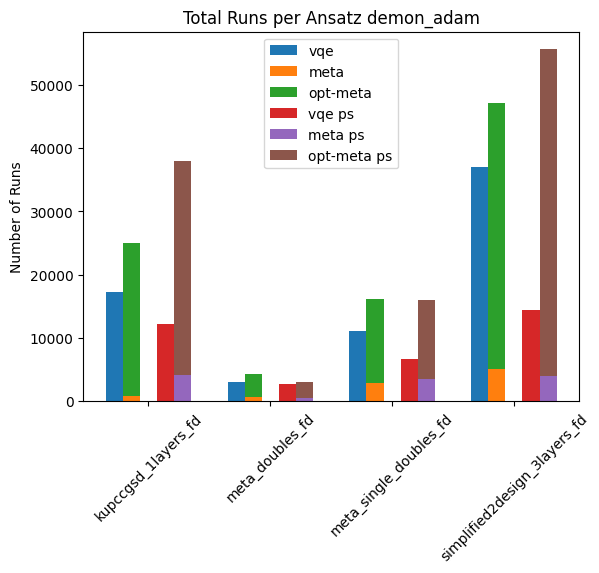

In [94]:
opt_runs = optimizers[3]

fig, ax = plt.subplots()

vqe_data = [condensed_data[idx][opt_runs]["runs"][0]*overheads[count] for count,idx in enumerate(index_per_runs_plot_fd)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][1]*overheads[count]*5 for count,idx in enumerate(index_per_runs_plot_fd)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][2]*overheads[count] for count,idx in enumerate(index_per_runs_plot_fd)]

vqe_data_ps = [condensed_data[idx][opt_runs]["runs"][0]*overheads[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs_ps = [condensed_data[idx][opt_runs]["runs"][1]*overheads[count]*5 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data_ps = [condensed_data[idx][opt_runs]["runs"][2]*overheads[count] for count,idx in enumerate(index_per_runs_plot_ps)]



ind = np.arange(len(vqe_data)) 

width = 0.14                    # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(2*width))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_data)), vqe_data, width=width, label = "vqe")
plt.bar(np.arange(len(meta_runs))+ width, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")

plt.bar(np.arange(len(vqe_data_ps))+ width*3, vqe_data_ps, width=width, label="vqe ps")
plt.bar(np.arange(len(meta_runs_ps))+ width*4, meta_runs_ps, width=width, label="meta ps")
plt.bar(np.arange(len(opt_meta_data_ps))+ width*4, opt_meta_data_ps, width=width, bottom= meta_runs_ps, label="opt-meta ps")
ax.legend()
plt.show()

[4150.000000000001, 455.00000000000006, 3484.0000000000005, 4002.0]


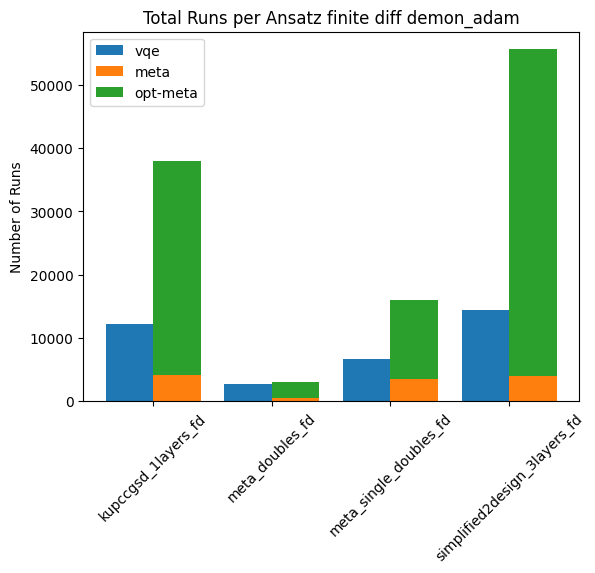

In [74]:
opt_runs = optimizers[3]

fig, ax = plt.subplots()

vqe_data = [condensed_data[idx][opt_runs]["runs"][0]*overheads[count] for count,idx in enumerate(index_per_runs_plot_ps)]
meta_runs = [condensed_data[idx][opt_runs]["runs"][1]*overheads[count]*5 for count,idx in enumerate(index_per_runs_plot_ps)]
opt_meta_data = [condensed_data[idx][opt_runs]["runs"][2]*overheads[count] for count,idx in enumerate(index_per_runs_plot_ps)]


print(meta_runs)


ind = np.arange(len(vqe_data)) 

width = 0.4                      # the width of the bars

ax.set_ylabel('Number of Runs')
ax.set_title(f'Total Runs per Ansatz finite diff {opt_runs}')
xTickMarks = [main_groups[idx] for idx in index_per_runs_plot_fd]
ax.set_xticks(ind+(width/2))
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)


plt.bar(np.arange(len(vqe_data)), vqe_data, width=width, label = "vqe")
plt.bar(np.arange(len(meta_runs))+ width, meta_runs, width=width, label="meta")
plt.bar(np.arange(len(opt_meta_data))+ width, opt_meta_data, width=width, bottom= meta_runs, label="opt-meta")
ax.legend()
plt.show()